In [160]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd.scipy.stats import norm
from autograd.scipy.special import gamma as gammaFn

from autograd import grad

%matplotlib inline

### Stein Variational Gradient Descent
#### by Qiang Liu, Dilin Wang (https://arxiv.org/abs/1608.04471)

Liu and Wang propose a general purpose algorithm for Bayesian inference.

In [161]:
def besselFn_helper(x, v=5, M=10):
    s = 0.
    for m in xrange(M):
        s += (1./(gammaFn(m+1)*gammaFn(m+v+1))) * (x/2.)**(2*m+v)
    return s

def besselFn(v, x):
    return np.pi/2. * (besselFn_helper(x,-v) - besselFn_helper(x,v))/np.sin(np.pi*v)

In [162]:
# Kernel Functions

# Radial Basis Function (Gaussian)
def rbf(x1, x2, params={'lengthScale': 1}):
    return np.exp((-.5/params['lengthScale']) * (x1-x2)**2)


# Matern
def matern(x1, x2, params={'v': 1 ,'l': 6.}):
    temp = ((np.sqrt(2*params['v'])/params['l']) * np.abs(x1-x2))
    return (2**(1-params['v'])/gammaFn(params['v'])) * temp**params['v'] * besselFn(params['v'], temp) 

In [163]:
### perform stein var. grad. descent
def steinOp(x, idx, dLogModel, params, kernel, kernelParams=None):
    returnVal = 0.
    n = len(x)
    for sampleIdx in xrange(n):
        if sampleIdx == idx: continue
        returnVal += kernel['f'](x[sampleIdx], x[idx])*dLogModel(x[idx], params) + kernel['df'](x[sampleIdx], x[idx])
    return 1./(n-1) * returnVal

In [164]:
### Gauss Mixture Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def logGaussMixPDF(x, params):
    return params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]})

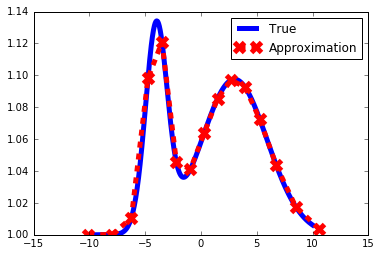

In [165]:
logModel = logGaussMixPDF
dLogModel = grad(logModel)
params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# kernel
kernel = {'f': rbf}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.normal

### generate samples
n = 15
x = []
for sampleIdx in xrange(n):
    x.append(q0())
    
maxEpochs = 100
lr = 2.
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)

x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.legend()